In [1]:
import matplotlib.image as mpimg   
import cv2                                         

In [2]:
import os
import math

In [3]:
import numpy as np 
import matplotlib.pyplot as plt
import math
import pandas as pd
from pathlib import Path

In [4]:
import colour as cl
from scipy import signal as sp
from numpy.linalg import norm

In [5]:
import seaborn as sns

In [6]:
import matplotlib.pyplot as plt

In [6]:
# функция для преобразоавания в градации серого
def rgb2gray(image_rgb):

    r, g, b = image_rgb[:,:,0], image_rgb[:,:,1], image_rgb[:,:,2]
    image_gray = np.round(0.2989 * r + 0.5870 * g + 0.1140 * b).astype(np.uint8)

    return image_gray

In [7]:
# функция для размывания изображений
def blurImage(image_gray, num):
    kernel = np.ones((num,num),np.float32)/4                     #Blurring kernel
    #We will skip first line and first column to keep it more simple, it's zeroed out anyway.
    #now for every pixel we change it with the average of 4 pixels(as the kernel): itself, pixel to left
    #pixel up, and pixel up-left. It drifts some edges one pixel to bottom-down, but it does not matter as
    #long as we use edged picture for the future work
    res=sp.convolve2d(image_gray,kernel,mode='same')
    
    return np.round(res).astype(np.uint8)

# Выделение зон аналитов

### Загрузка и визуализация изображений тест-полосок

(4096, 265, 3)


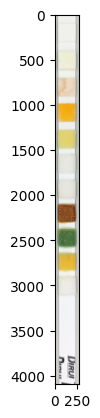

In [9]:
# глюкоза
stp0 = cv2.imread("imgs/glucose_calibration/10032024/60_renamed_strips/041.jpg")
stp0 = cv2.cvtColor(stp0, cv2.COLOR_BGR2RGB)
print(stp0.shape)
plt.imshow(stp0)
plt.show()

(3839, 249, 3)


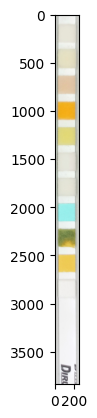

In [10]:
# альбумин
stp0 = cv2.imread("imgs/albumin_calibration/01052024/60_corrected_strips/IMG_20240501_094205.jpg")
stp0 = cv2.cvtColor(stp0, cv2.COLOR_BGR2RGB)
print(stp0.shape)
plt.imshow(stp0)
plt.show()

(3719, 256, 3)


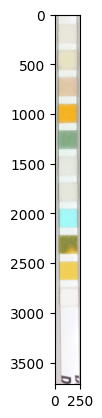

In [11]:
# альбумин
stp00 = cv2.imread("imgs/albumin_calibration/01052024/60_corrected_strips/IMG_20240501_104240.jpg")
stp00 = cv2.cvtColor(stp00, cv2.COLOR_BGR2RGB)
print(stp00.shape)
plt.imshow(stp00)
plt.show()

(4096, 265, 3)


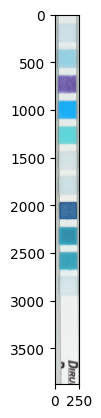

In [145]:
stp1 = cv2.imread("imgs/patients/05042024/60_corrected_strips/IMG_20240405_130040.jpg")
#stp1 = cv2.cvtColor(stp1, cv2.COLOR_BGR2RGB)
print(stp0.shape)
plt.imshow(stp1)
plt.show()

## поиск зон аналитов
### Глюкоза, функция для выделения зоны глюкозы

In [117]:
# функция для выделения зоны глюкозы
def find_glucose(strip):
    
    cnt = int(strip.shape[1]/2) # находим продольную середину стрипа
    band = strip[:3500, cnt-80:cnt+80, :] # вырезаем полоску по центру и укорачиваем
    #band = cv2.cvtColor(band, cv2.COLOR_BGR2RGB)
    gray = cv2.cvtColor(band, cv2.COLOR_BGR2GRAY) # переводим в серый цвет
    # выполняем бинарное преобразование изображения
    _, thresh = cv2.threshold(gray, 232, 200, 1)
    # усредняем значения по строкам
    averaged = thresh.sum(axis=1)/160
    # вычисляем разницу между значениями через 5 пикселей:
    contrast = averaged[10:]-averaged[:-10]
    # находим пики возрастаний на графике разниц
    peaks_top, _ = sp.find_peaks(contrast, height=20, distance = 240 )
    # находим пики убываний на графике разниц
    peaks_bottom, _ = sp.find_peaks(contrast*-1, height=20 , distance = 240 )
    # находим левую границу зоны глюкозы: первое возрастание после значения 1980
    gl_left = peaks_top[peaks_top>1820][0]
    # находим правую границу зоны глюкозы: первое убывание после возрастания на левой границе зоны глюкозы
    gl_right = peaks_bottom[peaks_bottom >gl_left][0]
    if (gl_right - gl_left)>350:
        gl_right = gl_left + 250
    # вырезаем зону глюкозы:
    glucose_pad = strip[gl_left:gl_right, :, :]
    
    
    return glucose_pad 

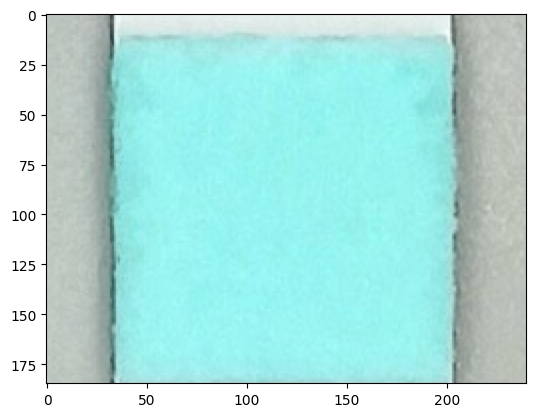

In [116]:
stp0 = cv2.imread("imgs/glucose/30032024/60_renamed_strips/001.jpg")
gl0 = find_glucose(stp0)
gl0 = cv2.cvtColor(gl0, cv2.COLOR_BGR2RGB)
plt.imshow(gl0)
plt.show()

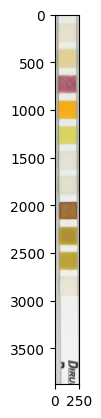

In [140]:
plt.imshow(stp1)
plt.show()

### Выделение изображений индикаторных зон глюкозы в заданной директории

In [132]:
# укажем путь к файлам и получим список файлов:
path = "imgs/glucose/10032024/60_renamed_strips2/"
files = os.listdir(path)

In [104]:
# укажем путь к файлам и получим список файлов:
path = "imgs/glucose/27032024/60_corrected_strips/"
files = os.listdir(path)

In [129]:
# создадим в директории дня новую директорую для всех аналитов
glucose_path = os.path.join(str(Path(path).parents[0]), '60_glucose2')
os.mkdir(glucose_path)

In [130]:
glucose_path

'imgs\\glucose\\30032024\\60_glucose2'

In [1598]:
analytes_path

'imgs\\patients\\21032024\\60_analytes'

In [45]:
# функция для извлечения и сохранения изображений тест-полосок
def glucose_extraction(path, filename, glucose_path):
    """
    Функция для выделения изображений зон аналитов для файлов в директории
    path - путь к файлам с изображениями тест-полосок
    filename - имя исходного файла
    """
    img = cv2.imread(path + filename) # читаем файл
    glucose_pad = find_glucose(img) # извлекаем изображения полосок
    cv2.imwrite(os.path.join(glucose_path ,filename), glucose_pad)            
    
    return glucose_pad 

Выделим изображения:

In [131]:
for item in files:
    gl_pad = glucose_extraction(path, item, glucose_path)

### Альбумин, функция для выделения индикаторных зон

In [13]:
# функция для выделения зоны глюкозы
def find_albumin(strip):
    
    cnt = int(strip.shape[1]/2) # находим продольную середину стрипа
    band = strip[:3500, cnt-80:cnt+80, :] # вырезаем полоску по центру и укорачиваем
    #band = cv2.cvtColor(band, cv2.COLOR_BGR2RGB)
    gray = cv2.cvtColor(band, cv2.COLOR_BGR2GRAY) # переводим в серый цвет
    # выполняем бинарное преобразование изображения
    _, thresh = cv2.threshold(gray, 232, 200, 1)
    # усредняем значения по строкам
    averaged = thresh.sum(axis=1)/160
    # вычисляем разницу между значениями через 5 пикселей:
    contrast = averaged[10:]-averaged[:-10]
    # находим пики возрастаний на графике разниц
    peaks_top, _ = sp.find_peaks(contrast, height=20, distance = 240 )
    # находим пики убываний на графике разниц
    peaks_bottom, _ = sp.find_peaks(contrast*-1, height=20 , distance = 240 )
    # находим левую границу зоны глюкозы: первое возрастание после значения 1980
    al_left = peaks_top[peaks_top>1100][0]
    # находим правую границу зоны глюкозы: первое убывание после возрастания на левой границе зоны глюкозы
    al_right = peaks_bottom[peaks_bottom >al_left][0]
    if (al_right - al_left)>350:
        al_right = al_left + 250
    # вырезаем зону глюкозы:
    albumin_pad = strip[al_left:al_right, :, :]
    
    
    return albumin_pad 

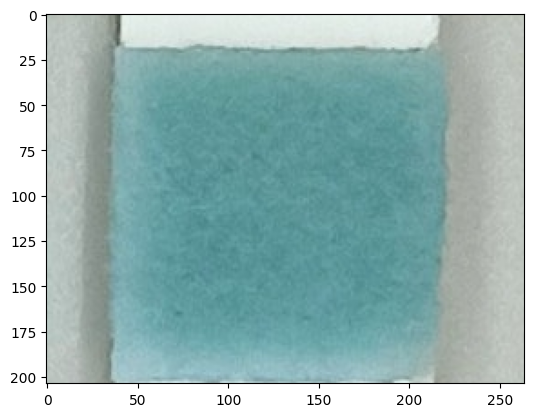

In [24]:
stp0 = cv2.imread("imgs/albumin_calibration/01052024/60_corrected_strips2/IMG_20240501_121430.jpg")
gl0 = find_albumin(stp0)
gl0 = cv2.cvtColor(gl0, cv2.COLOR_BGR2RGB)
plt.imshow(gl0)
plt.show()

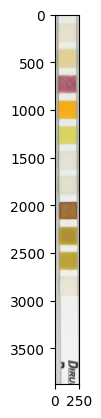

In [140]:
plt.imshow(stp1)
plt.show()

### Выделение индикаторных зон альбумина (белка) из изображений тест-полосок в заданной директории

In [27]:
# укажем путь к файлам и получим список файлов:
path = "imgs/albumin_calibration/01052024/60_corrected_strips/"
files = os.listdir(path)
len(files)

54

In [37]:
# укажем путь к файлам и получим список файлов:
path = "imgs/albumin_calibration/01052024/60_corrected_strips2/"
files = os.listdir(path)
len(files)

50

In [128]:
path

'imgs/glucose/30032024/60_renamed_strips2/'

In [30]:
# создадим в директории дня новую директорую для всех аналитов
albumin_path = os.path.join(str(Path(path).parents[0]), '60_pads_1')
os.mkdir(albumin_path)

In [38]:
# создадим в директории дня новую директорую для всех аналитов
albumin_path = os.path.join(str(Path(path).parents[0]), '60_pads_2')
os.mkdir(albumin_path)

In [31]:
albumin_path

'imgs\\albumin_calibration\\01052024\\60_pads_1'

In [35]:
# функция для извлечения и сохранения изображений тест-полосок
def albumin_extraction(path, filename, albumin_path):
    """
    Функция для выделения изображений зон аналитов для файлов в директории
    path - путь к файлам с изображениями тест-полосок
    filename - имя исходного файла
    """
    img = cv2.imread(path + filename) # читаем файл
    albumin_pad = find_albumin(img) # извлекаем изображения полосок
    cv2.imwrite(os.path.join(albumin_path ,filename), albumin_pad)            
    
    return albumin_pad 

### выделим изображения:

In [39]:
for item in files:
    albumin_pad = albumin_extraction(path, item, albumin_path)

## Все аналиты

### Функция для корректровки перечня найденных пиков (используется в функции поиска индикаторных зон)

In [134]:
# функция для корректировки перечня найденных пиков
def adjust_peaks(peaks, bottom = 1):
    
    
    # найдем индексы пиков, которые удалены от двух соседей более чем на 330 пикселей
    bad_indx = []
    for i in range(len(peaks)-1):
        if ((abs(peaks[i]- peaks[i-1]) >330) and (abs(peaks[i]- peaks[i+1]) >330)):
            bad_indx.append(i)
                                         
    if (peaks[-1] - peaks[-2])>330:
        bad_indx.append(-1)
    
    # удалим пики, удаленные от соседей более чем на 330 пикселей:
    peaks = np.delete(peaks, bad_indx)
    
    # расстояния между пиками
    distances = (peaks[1:]-peaks[:-1])
    # среднее расстояние для пиков, удаленных менее чем на 330 пикселей
    avg_distance = int(np.mean(distances[distances<330]))
    
    # вычислим положения пиков, пропущенных в середине
    # индексы для пропусков - разрывов более чем на 300 пикселей
    gap_indx = np.nonzero(distances > 330)[0]
    missed_points = []
    for i in range(len(gap_indx)):
        long_gap = distances[gap_indx[i]]
        points = int(np.round(distances[gap_indx[i]]/avg_distance))
        calculated = int(long_gap/points)
        for n in range(points-1):
            point = peaks[gap_indx[i]] + calculated*(n+1)
            missed_points.append(point)
            
    # добавим пропущенные пики и отсортируем
    adjusted_peaks = np.sort(np.insert(peaks, 0, missed_points))
    
    # добавляем пропущенные пики в начале
    while adjusted_peaks[0]-avg_distance > bottom*220:
        adjusted_peaks = np.insert(adjusted_peaks, 0, (adjusted_peaks[0]-avg_distance))
    
    #добавляем пропущенные пады в конце
    while len(adjusted_peaks) < 11:
        adjusted_peaks = np.sort(np.insert(adjusted_peaks, -1, adjusted_peaks[-1]+avg_distance))
        
        
    return adjusted_peaks   

### Функция для выделения зон аналитов из изображения тест-полоски

In [135]:
# функция для выделения зон аналитов
def find_pads(strip):
    
    cnt = int(strip.shape[1]/2) # находим продольную середину стрипа
    band = strip[:3500, cnt-80:cnt+80, :] # вырезаем полоску по центру и укорачиваем
    #band = cv2.cvtColor(band, cv2.COLOR_BGR2RGB)
    gray = cv2.cvtColor(band, cv2.COLOR_BGR2GRAY) # переводим в серый цвет
    # выполняем бинарное преобразование изображения
    _, thresh = cv2.threshold(gray, 228, 200, 1)
    # усредняем значения по строкам
    averaged = thresh.sum(axis=1)/160
    # вычисляем разницы между значениями через 5 пикселей:
    contrast = averaged[10:]-averaged[:-10]
    # находим пики возрастаний на графике разниц
    peaks_top, _ = sp.find_peaks(contrast, height=20, distance = 240 )
    # находим пики убываний на графике разниц
    peaks_bottom, _ = sp.find_peaks(contrast*-1, height=20 , distance = 240 )
    # удаляем границы убывания, близкие к началу стрипа
    peaks_bottom = peaks_bottom[peaks_bottom > 250]
    
    # корректируем найденные пики, определяя левые границы:
    left_borders = adjust_peaks(peaks_top, bottom = 0)
    right_borders = adjust_peaks(peaks_bottom, bottom = 1)
    
        
    # выделяем зоны:
    if left_borders[0]<right_borders[0]:
        ubg = strip[left_borders[0]:right_borders[0], :, :]
        bil = strip[left_borders[1]:right_borders[1], :, :]
        keton = strip[left_borders[2]:right_borders[2], :, :]
        blood = strip[left_borders[3]:right_borders[3], :, :]
        protein =  strip[left_borders[4]:right_borders[4], :, :]
        nit = strip[left_borders[5]:right_borders[5], :, :]
        leu = strip[left_borders[6]:right_borders[6], :, :]
        glucose = strip[left_borders[7]:right_borders[7], :, :]
        gravity = strip[left_borders[8]:right_borders[8], :, :]
        ph = strip[left_borders[9]:right_borders[9], :, :]
        blank = strip[left_borders[10]:right_borders[10], :, :]
    
    pads = [ubg, bil, keton, blood, protein, nit, leu, glucose, gravity, ph, blank]
    
    
    return pads
    
    

### Проверка работы функции выделения изображений индикаторных зон

Проверяем: применяем функцию к изображению тест-полоски

In [146]:
ubg, bil, keton, blood, protein, nit, leu, glucose, gravity, ph, blank = find_pads(stp1)

In [ ]:

analytes = [ubg, bil, keton, blood, protein,
            nit, leu, glucose, gravity, ph, blank]

In [143]:
# названия аналитов
names = ['urobilinogen', 'bilirubin', 'ketones', 'blood', 'protein',
         'nitrites', 'leucocytes', 'glucose', 'gravity', 'pH', 'blank']

Визуализируем полученные индикаторные зоны

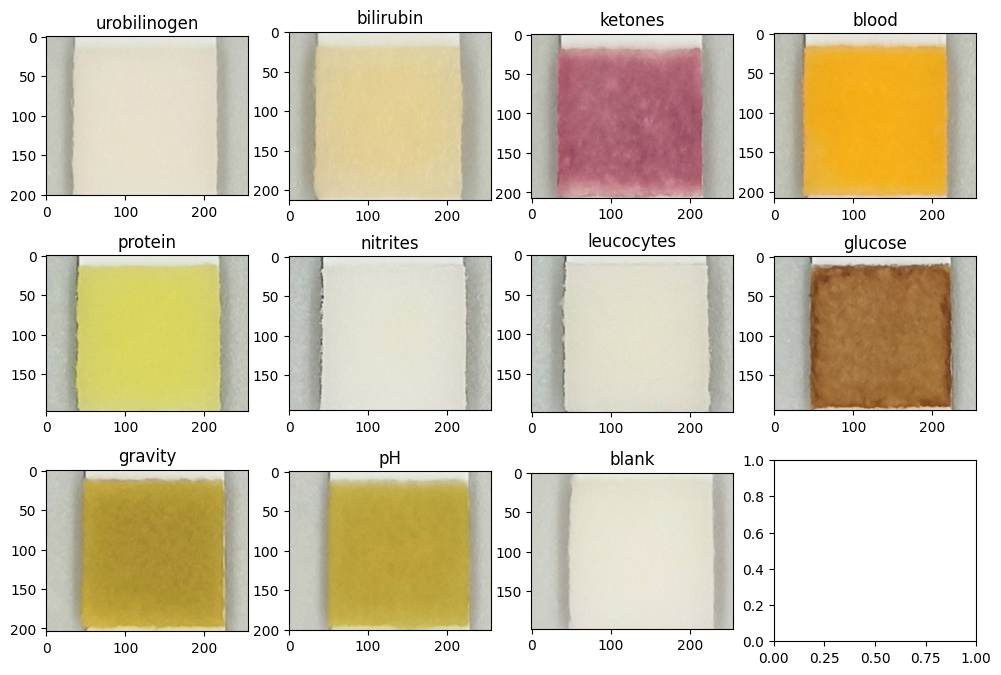

In [147]:
fig, ax = plt.subplots(3,4, figsize=(12,8))
ax[0,0].imshow(cv2.cvtColor(ubg, cv2.COLOR_BGR2RGB))
ax[0,0].set_title('urobilinogen')
ax[0,1].imshow(cv2.cvtColor(bil, cv2.COLOR_BGR2RGB))
ax[0,1].set_title('bilirubin')
ax[0,2].imshow(cv2.cvtColor(keton, cv2.COLOR_BGR2RGB))
ax[0,2].set_title('ketones')
ax[0,3].imshow(cv2.cvtColor(blood, cv2.COLOR_BGR2RGB))
ax[0,3].set_title('blood')
ax[1,0].imshow(cv2.cvtColor(protein, cv2.COLOR_BGR2RGB))
ax[1,0].set_title('protein')
ax[1,1].imshow(cv2.cvtColor(nit, cv2.COLOR_BGR2RGB))
ax[1,1].set_title('nitrites')
ax[1,2].imshow(cv2.cvtColor(leu, cv2.COLOR_BGR2RGB))
ax[1,2].set_title('leucocytes')
ax[1,3].imshow(cv2.cvtColor(glucose, cv2.COLOR_BGR2RGB))
ax[1,3].set_title('glucose')
ax[2,0].imshow(cv2.cvtColor(gravity, cv2.COLOR_BGR2RGB))
ax[2,0].set_title('gravity')
ax[2,1].imshow(cv2.cvtColor(ph, cv2.COLOR_BGR2RGB))
ax[2,1].set_title('pH')
ax[2,2].imshow(cv2.cvtColor(blank, cv2.COLOR_BGR2RGB))
ax[2,2].set_title('blank')

plt.show()

In [148]:
stp_pt = cv2.imread("imgs/patients/22032024/60_corrected_extracted/IMG_20240322_124020.jpg")
ubg, bil, keton, blood, protein, nit, leu, glucose, gravity, ph, blank = find_pads(stp_pt)

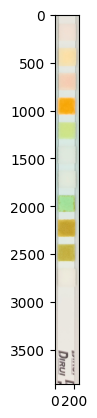

In [149]:
stp_pt = cv2.imread("imgs/patients/27032024/60_corrected_strips/IMG_20240327_115827.jpg")
plt.imshow(cv2.cvtColor(stp_pt, cv2.COLOR_BGR2RGB))

In [150]:
pads = find_pads(stp_pt)

In [151]:
len(pads)

11

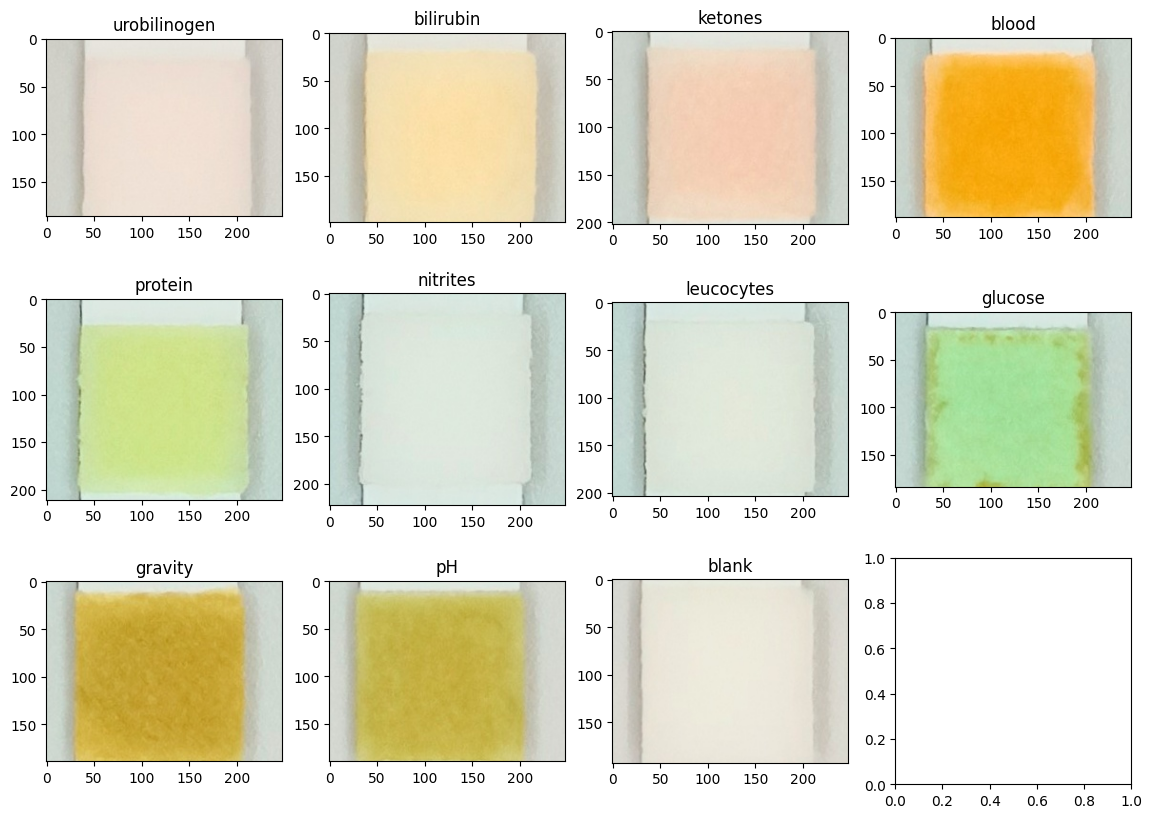

In [152]:
fig, ax = plt.subplots(3,4, figsize=(14,10))
ax[0,0].imshow(cv2.cvtColor(pads[0], cv2.COLOR_BGR2RGB))
ax[0,0].set_title('urobilinogen')
ax[0,1].imshow(cv2.cvtColor(pads[1], cv2.COLOR_BGR2RGB))
ax[0,1].set_title('bilirubin')
ax[0,2].imshow(cv2.cvtColor(pads[2], cv2.COLOR_BGR2RGB))
ax[0,2].set_title('ketones')
ax[0,3].imshow(cv2.cvtColor(pads[3], cv2.COLOR_BGR2RGB))
ax[0,3].set_title('blood')
ax[1,0].imshow(cv2.cvtColor(pads[4], cv2.COLOR_BGR2RGB))
ax[1,0].set_title('protein')
ax[1,1].imshow(cv2.cvtColor(pads[5], cv2.COLOR_BGR2RGB))
ax[1,1].set_title('nitrites')
ax[1,2].imshow(cv2.cvtColor(pads[6], cv2.COLOR_BGR2RGB))
ax[1,2].set_title('leucocytes')
ax[1,3].imshow(cv2.cvtColor(pads[7], cv2.COLOR_BGR2RGB))
ax[1,3].set_title('glucose')
ax[2,0].imshow(cv2.cvtColor(pads[8], cv2.COLOR_BGR2RGB))
ax[2,0].set_title('gravity')
ax[2,1].imshow(cv2.cvtColor(pads[9], cv2.COLOR_BGR2RGB))
ax[2,1].set_title('pH')
ax[2,2].imshow(cv2.cvtColor(pads[10], cv2.COLOR_BGR2RGB))
ax[2,2].set_title('blank')

plt.show()

### Извлечение изображений индикаторных зон из файлов в заданной директории

In [153]:
analytes = ['urobilinogen', 'bilirubin', 'ketones', 'blood', 'protein',
         'nitrites', 'leucocytes', 'glucose', 'gravity', 'pH', 'blank']

In [161]:
# укажем путь к файлам и получим список файлов:
path = "imgs/patients/08042024/60_corrected_strips/"
files = os.listdir(path)

In [162]:
files

['IMG_20240408_130728.jpg',
 'IMG_20240408_130841.jpg',
 'IMG_20240408_130955.jpg',
 'IMG_20240408_131110.jpg',
 'IMG_20240408_131425.jpg',
 'IMG_20240408_131539.jpg',
 'IMG_20240408_131654.jpg',
 'IMG_20240408_131808.jpg',
 'IMG_20240408_131924.jpg',
 'IMG_20240408_132039.jpg',
 'IMG_20240408_132157.jpg',
 'IMG_20240408_132310.jpg',
 'IMG_20240408_132425.jpg',
 'IMG_20240408_132540.jpg',
 'IMG_20240408_132654.jpg',
 'IMG_20240408_132808.jpg',
 'IMG_20240408_132925.jpg',
 'IMG_20240408_133041.jpg',
 'IMG_20240408_133154.jpg',
 'IMG_20240408_133310.jpg']

In [163]:
len(files)

20

In [164]:
# создадим в директории дня новую директорую для всех аналитов
analytes_path = os.path.join(str(Path(path).parents[0]), '60_analytes')
os.mkdir(analytes_path)

In [165]:
analytes_path

'imgs\\patients\\08042024\\60_analytes'

In [166]:
# создадим директории для извлеченных зон аналитов
for analyt in analytes:
    an_path = os.path.join(analytes_path, analyt)
    os.mkdir(an_path)

In [159]:
# функция для извлечения и сохранения изображений тест-полосок
def pad_extraction(path, filename):
    """
    Функция для выделения изображений зон аналитов для файлов в директории
    path - путь к файлам с изображениями тест-полосок
    filename - имя исходного файла
    """
    img = cv2.imread(path + filename) # читаем файл
    pads = find_pads(img) # извлекаем изображения полосок
    analytes_path = os.path.join(str(Path(path).parents[0]), '60_analytes')
    
    if len(pads) ==11:
        for i in range(11):
            analyt_path = os.path.join(analytes_path, analytes[i])
            cv2.imwrite(os.path.join(analyt_path ,filename), pads[i])            
    
    return pads  

In [167]:
for item in files:
    pads_1 = pad_extraction(path, item)

Проблемные файлы:
IMG_20240327_115827 - 27 03 2024 - сдвиг на два аналита для некоторых зон - изменен порог бинаризации с 232 на 228

29.03.2024 - IMG_20240329_125821 - сдвиг на неправильные зоны (11 файл) - были укороченные полоски, изменен порог Canny с 120 на 80
             IMG_20240329_130717 - неправильная обрезка (16 файл)
             






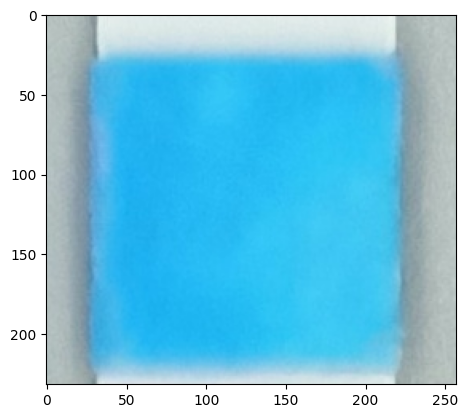

In [1513]:
plt.imshow(blood)
plt.show()

## Ячейки для отладки функций для выделения индикаторных зон

(3859, 248, 3)


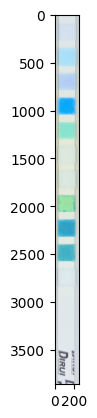

In [1646]:
stp1 = cv2.imread("imgs/patients/27032024/60_corrected_strips/IMG_20240327_115827.jpg")
#stp0 = cv2.cvtColor(stp0, cv2.COLOR_BGR2RGB)
print(stp1.shape)
plt.imshow(stp1)
plt.show()

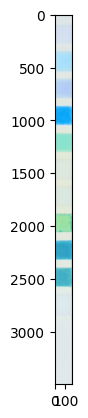

In [1647]:
cnt = int(stp1.shape[1]/2)
gl = stp1[:3500, cnt-80:cnt+80, :]
plt.imshow(gl)
plt.show()

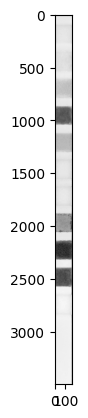

(3500, 160)

In [1648]:
gr = cv2.cvtColor(gl, cv2.COLOR_BGR2GRAY)
plt.imshow(gr, cmap='gray')
plt.show()
gr.shape

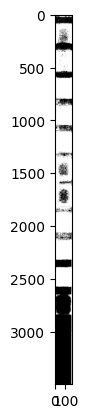

In [1657]:
# пороги для тест-полоски
ret, thresh_pad = cv2.threshold(gr, 228, 200, 1)
plt.imshow(thresh_pad, cmap='gray')
plt.show()

In [1658]:
tr_sum = thresh_pad.sum(axis=1)/160

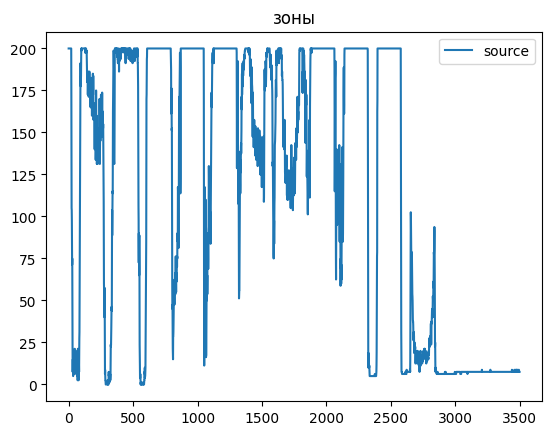

In [1659]:
plt.plot(tr_sum); plt.legend(['source'])
plt.title('зоны')
plt.show()

In [1660]:
contr = tr_sum[10:]-tr_sum[:-10]

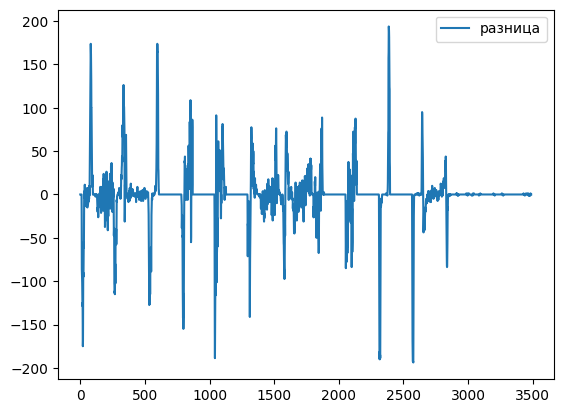

In [1661]:
plt.plot(contr); plt.legend(['разница'])
plt.show()

In [1662]:
peaks_top, _ = sp.find_peaks(contr, height=20, distance = 240)

In [1663]:
peaks_top

array([  81,  335,  596,  853, 1101, 1516, 1871, 2130, 2387, 2645], dtype=int64)

In [1664]:
# рассятония между пиками на возрастание
distances_top = (peaks_top[1:]-peaks_top[:-1])
distances_top, len(distances_top)

(array([254, 261, 257, 248, 415, 355, 259, 257, 258], dtype=int64), 9)

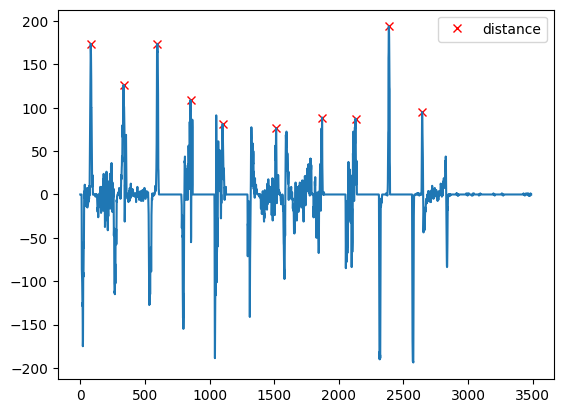

In [1665]:
plt.plot(peaks_top, contr[peaks_top], "xr"); plt.plot(contr); plt.legend(['distance'])
plt.show()

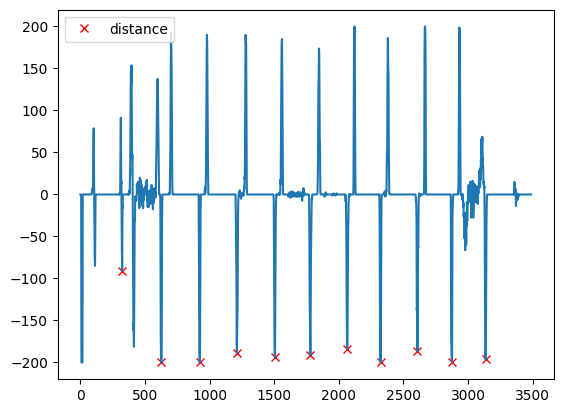

In [1497]:
plt.plot(peaks_bottom, contr[peaks_bottom], "xr"); plt.plot(contr); plt.legend(['distance'])
plt.show()

In [1481]:
peaks_top

array([ 104,  396,  703,  980, 1279, 1560, 1847, 2122, 2380, 2667, 2933], dtype=int64)

In [1498]:
peaks_bottom, _ = sp.find_peaks(contr*-1, height=20 , distance = 240 )

In [1499]:
peaks_bottom

array([  12,  324,  626,  924, 1212, 1506, 1780, 2066, 2324, 2609, 2876,
       3136], dtype=int64)

In [1500]:
peaks_bottom = peaks_bottom[peaks_bottom > 250]

In [1501]:
peaks_bottom

array([ 324,  626,  924, 1212, 1506, 1780, 2066, 2324, 2609, 2876, 3136], dtype=int64)

In [1666]:
adj_top = adjust_peaks(peaks_top, bottom=0)
adj_top

array([  81,  335,  596,  853, 1101, 1357, 1613, 1871, 2130, 2387, 2645], dtype=int64)

In [1485]:
adj_bottom = adjust_peaks(peaks_bottom, bottom=1)
adj_bottom

array([  12,  324,  626,  924, 1212, 1506, 1780, 2066, 2324, 2609, 2876,
       3136], dtype=int64)

In [1488]:
# удаляем первую границу убывания
if peaks_bottom[0] < 250:
    peaks_bottom = np.delete(peaks_bottom, 0)

In [1489]:
peaks_bottom

array([ 324,  626,  924, 1212, 1506, 1780, 2066, 2324, 2609, 2876, 3136], dtype=int64)

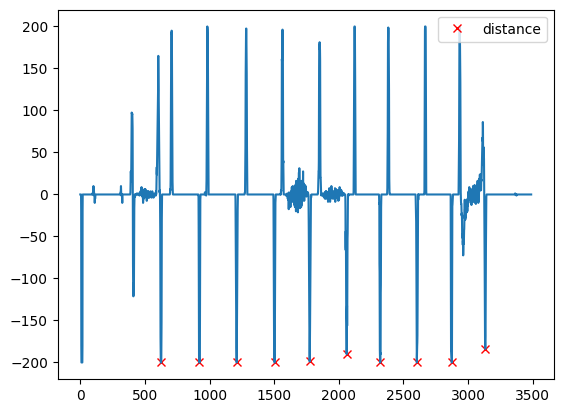

In [1385]:
plt.plot(peaks_bottom, contr[peaks_bottom], "xr"); plt.plot(contr); plt.legend(['distance'])
plt.show()

In [1361]:
def adjust_peaks(peaks, bottom = 1):
    
    
    # найдем индексы пиков, которые удалены от двух соседей более чем на 330 пикселей
    bad_indx = []
    for i in range(len(peaks)-1):
        if ((abs(peaks[i]- peaks[i-1]) >330) and (abs(peaks[i]- peaks[i+1]) >330)):
            bad_indx.append(i)
                                         
    if (peaks[-1] - peaks[-2])>330:
        bad_indx.append(-1)
    
    # удалим пики, удаленные от соседей более чем на 330 пикселей:
    peaks = np.delete(peaks, bad_indx)
    
    # расстояния между пиками
    distances = (peaks[1:]-peaks[:-1])
    # среднее расстояние для пиков, удаленных менее чем на 330 пикселей
    avg_distance = int(np.mean(distances[distances<330]))
    
    # вычислим положения пиков, пропущенных в середине
    # индексы для пропусков - разрывов более чем на 300 пикселей
    gap_indx = np.nonzero(distances > 330)[0]
    missed_points = []
    for i in range(len(gap_indx)):
        long_gap = distances[gap_indx[i]]
        points = int(np.round(distances[gap_indx[i]]/avg_distance))
        calculated = int(long_gap/points)
        for n in range(points-1):
            point = peaks[gap_indx[i]] + calculated*(n+1)
            missed_points.append(point)
            
    # добавим пропущенные пики и отсортируем
    adjusted_peaks = np.sort(np.insert(peaks, 0, missed_points))
    
    # добавляем пропущенные пики в начале
    while adjusted_peaks[0]-avg_distance > bottom*220:
        adjusted_peaks = np.insert(adjusted_peaks, 0, (adjusted_peaks[0]-avg_distance))
    
    #добавляем пропущенные пады в конце
    while len(adjusted_peaks) < 11:
        adjusted_peaks = np.sort(np.insert(adjusted_peaks, -1, adjusted_peaks[-1]+avg_distance))
        
        
    return adjusted_peaks   
    

In [1386]:
peaks_top

array([ 398,  707,  983, 1284, 1565, 1852, 2123, 2383, 2669, 2937], dtype=int64)

In [1388]:
adjust_peaks(peaks_top, bottom = 0)

array([ 116,  398,  707,  983, 1284, 1565, 1852, 2123, 2383, 2669, 2937], dtype=int64)

In [1389]:
peaks_bottom

array([ 624,  922, 1210, 1503, 1775, 2061, 2320, 2604, 2874, 3134], dtype=int64)

In [1390]:
adjust_peaks(peaks_bottom, bottom = 1)

array([ 346,  624,  922, 1210, 1503, 1775, 2061, 2320, 2604, 2874, 3134], dtype=int64)

In [1366]:
peaks_sim = np.array([390, 693, 1259, 1533, 1811, 2612])

In [1362]:
peaks_sim

array([ 390,  693, 1259, 1533, 1811, 2612, 2891])

In [1367]:
adj_sim = adjust_peaks(peaks_sim, bottom = 0)

In [1368]:
adj_sim

array([ 105,  390,  693,  976, 1259, 1533, 1811, 2096, 2381, 2666, 2951])

In [1365]:
peaks_top

array([ 107,  390,  693,  976, 1259, 1533, 1811, 2074, 2330, 2612, 2891], dtype=int64)

In [1348]:
# рассятония между пиками на возрастание
distances_top = (peaks_top[1:]-peaks_top[:-1])
distances_top, len(distances_top)

(array([283, 303, 283, 283, 274, 278, 263, 256, 282, 279], dtype=int64), 10)

In [1349]:
# расстояния между пиками на убывание
distances_bottom = (peaks_bottom[1:]-peaks_bottom[:-1])
distances_bottom, len(distances_bottom)

(array([291, 292, 286, 281, 277, 287, 275, 273, 261, 252], dtype=int64), 10)

In [1350]:
# средние расстояния между пиками сверху и снизу
# для расстояний, котрорые не превышают ширину зоны аналита
avg_top = int(np.mean(distances_top[distances_top<330]))
avg_bottom = int(np.mean(distances_bottom[distances_bottom<330]))
avg_top, avg_bottom

(278, 277)

In [1351]:
# найдем индексы пиков, которые удалены от соседей более чем на 330 пикселей
bad_top = []
for i in range(len(peaks_top)-1):
    if ((abs(peaks_top[i]- peaks_top[i-1]) >350) and (abs(peaks_top[i]- peaks_top[i+1]) >330)):
        print('big', peaks_top[i])
        bad_top.append(i)
                                         
if (peaks_top[-1] - peaks_top[-2])>330:
    bad_top.append(-1)

In [1352]:
# найдем индексы пиков, которые удалены от соседей более чем на 330 пикселей
bad_bottom = []
for i in range(len(peaks_bottom)-1):
    if ((abs(peaks_top[i]- peaks_top[i-1]) >350) and (abs(peaks_top[i]- peaks_top[i+1]) >330)):
        print('big', peaks_top[i])
        bad_top.append(i)
                                         
if (peaks_top[-1] - peaks_top[-2])>330:
    bad_top.append(-1)

[]

In [1148]:
peaks_top

5

In [1203]:
# найдем индексы пиков, которые удалены от остальных пиков более чем на 350 пикселей
bad_indx = []
for i in range(len(peaks_top)-1):
    if ((abs(peaks_top[i]- peaks_top[i-1]) >350) and (abs(peaks_top[i]- peaks_top[i+1]) >350)):
        print('big', peaks_top[i])
        bad_indx.append(i)
                                         
if (peaks_top[-1] - peaks_top[-2])>350:
    bad_indx.append(-1)

big 320


In [1204]:
bad_indx

[0, -1]

In [1205]:
# удалим пики, которые 
peaks_top = np.delete(peaks_top, bad_indx)

In [686]:
gl_left = peaks_top[peaks_top>2000][0]
gl_left

2008

In [680]:
gl_right = peaks_bottom[peaks_bottom >gl_left][0]
gl_right

2227

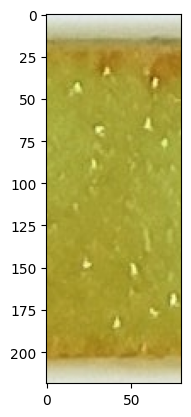

In [681]:
cnt = int(stp0.shape[1]/2)
gl = stp0[gl_left:gl_right, cnt-40:cnt+40, :]

plt.imshow(gl)
plt.show()

In [749]:
peaks_sim = np.array([78,365,1215,1481,1753,2008,2537])
peaks_sim

array([  78,  365, 1215, 1481, 1753, 2008, 2537])

In [750]:
peaks_top

array([  78,  365,  655,  927, 1215, 1481, 1753, 2008, 2537], dtype=int64)

In [1162]:
1215-927

288

In [773]:
missed_points

[648, 931, 2272]

In [753]:
distances_top = (peaks_sim[1:]-peaks_sim[:-1])
distances_top, len(distances_top)

(array([287, 850, 266, 272, 255, 529]), 6)

In [769]:
big_indx = np.nonzero(distances_top > 330)[0]
big_indx

array([1, 5], dtype=int64)

In [755]:
distances_top[distances_top<330]

array([287, 266, 272, 255])

In [756]:
distances_top[0]

287

In [757]:
big_indx[1]

5

In [758]:
# среднее расстояние
avg_dist = int(np.mean(distances_top[distances_top<330]))
avg_dist

270

In [759]:
long = distances_top[big_indx[0]]
long

850

In [760]:
len(big_indx)

2

In [761]:
points = int(np.round(distances_top[big_indx[0]]/avg_dist))
points

3

In [767]:
int(long/points)

283

In [764]:
peaks_sim[big_indx[0]]+avg_dist*1

635

In [779]:
# заполняем пробелы
missed_points = []
for i in range(len(big_indx)):
    long_gap = distances_top[big_indx[i]]
    points = int(np.round(distances_top[big_indx[i]]/avg_dist))
    calc_dist = int(long_gap/points)
    for n in range(points-1):
        point = peaks_sim[big_indx[i]] + calc_dist*(n+1)
        missed_points.append(point)
        

In [780]:
missed_points

[648, 931, 2272]

In [776]:
peaks_t = np.sort(np.insert(peaks_sim, 0, missed_points))

In [777]:
peaks_t

array([  78,  365,  648,  931, 1215, 1481, 1753, 2008, 2272, 2537])

In [786]:
avg_gap = int(np.round(np.mean(peaks_t[1:]-peaks_t[:-1])))
avg_gap

273

In [797]:
# добавляем пропущенные пады в начале
while peaks_t[0]-avg_gap > 0:
    peaks_t = np.insert(peaks_t,0, (peaks_t[0]-avg_gap))
    
#добавляем пропущенные пады в конце
while len(peaks_t) < 11:
    peaks_t = np.sort(np.insert(peaks_t, -1, peaks_t[-1]+avg_gap))

In [804]:
#добавляем пропущенные пады в конце
while len(peaks_t) < 11:
    peaks_t = np.sort(np.insert(peaks_t, -1, peaks_t[-1]+avg_gap))

In [805]:
peaks_t

array([  78,  365,  648,  931, 1215, 1481, 1753, 2008, 2272, 2537, 2810])

In [800]:
peaks_t[-1]

2537

In [803]:
pt = np.sort(np.insert(peaks_t, -1, peaks_t[-1]+avg_gap))
pt

array([  78,  365,  648,  931, 1215, 1481, 1753, 2008, 2272, 2537, 2810])

In [793]:
tt = np.array([10, 12, 14, 45])
vg = 3

In [794]:
tt

array([10, 12, 14, 45])

In [795]:
while tt[0]-vg > 0:
    tt = np.insert(tt,0, (tt[0]-vg))

In [796]:
tt

array([ 1,  4,  7, 10, 12, 14, 45])

In [778]:
len(peaks_t)

10

In [748]:
for point in range(points-1):
    print(point)

0
1


In [709]:
for i in range(len(big_indx)):
    print(i)

0


In [ ]:
missed 

In [692]:
peaks_top[big_ind[0]+1]

array([2537], dtype=int64)

In [ ]:
gl_right = peaks_

In [354]:
np.min(contr*-1)

-190.0

In [423]:
peaks

array([ 123,  404,  709,  987, 1287, 1565, 1854, 2126, 2386, 2673, 2939], dtype=int64)

In [424]:
len(peaks)

11

In [416]:
if len(peaks) < 11:
    distances_top = peaks[1:]-peaks[:-1]
    avg_dist = int(np.mean(distances_top[distances_top<400]))
    if peaks[0]-avg_dist > 0:
        first = peaks[0] - avg_dist
        peaks = np.insert(peaks, 0, first)
    while len(peaks) < 11:
        for i in range(len(peaks)-1):
            if (peaks[i+1] - peaks[i]) > 400:
                next_peak = 
            
            

In [422]:
for i in range(1):
    print(i)

0


In [417]:
peaks

array([ 123,  404,  709,  987, 1287, 1565, 1854, 2126, 2386, 2673, 2939], dtype=int64)

In [398]:
distances_top

array([305, 278, 300, 278, 289, 272, 260, 287, 266], dtype=int64)

In [403]:
# среднее значение дистанции для дистанций менее 400
int(np.mean(distances_top[distances_top<400]))

281

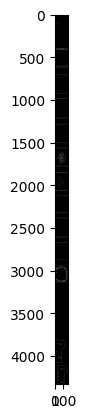

In [222]:
edged_pad = cv2.Canny(thresh_pad, 2, 40)
plt.imshow(edged_pad, cmap='gray')
plt.show()

<Axes: xlabel='None', ylabel='vals'>

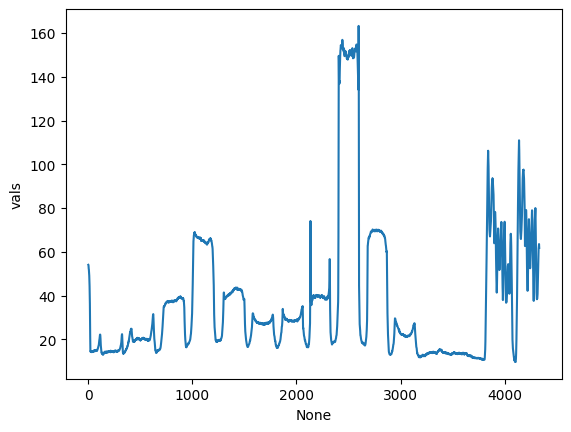

In [250]:
sns.lineplot(data=dataset, x=dataset.index, y='vals')

Text(0.5, 1.0, 'зоны на полоске')

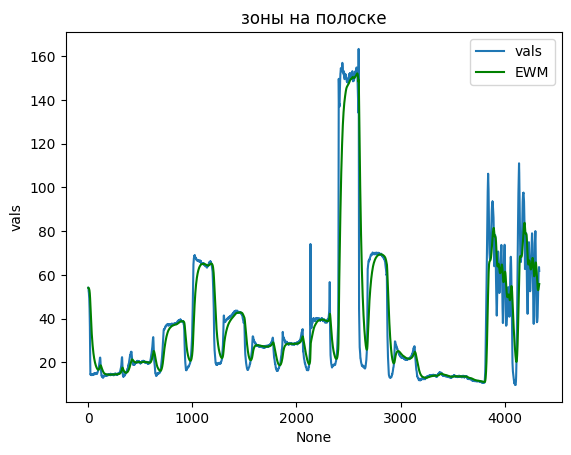

In [294]:
fig, ax=plt.subplots()
sns.lineplot(data=dataset, x=dataset.index, y='vals', label = 'vals')
sns.lineplot(data=dataset, x=dataset.index, y='ewm', color = 'g', label = 'EWM')
#sns.lineplot(data=gl_calibration, x='concentration', y = 'B', color = 'b', label = 'B')
ax.set_title('зоны на полоске')

Text(0.5, 1.0, 'зоны на полоске')

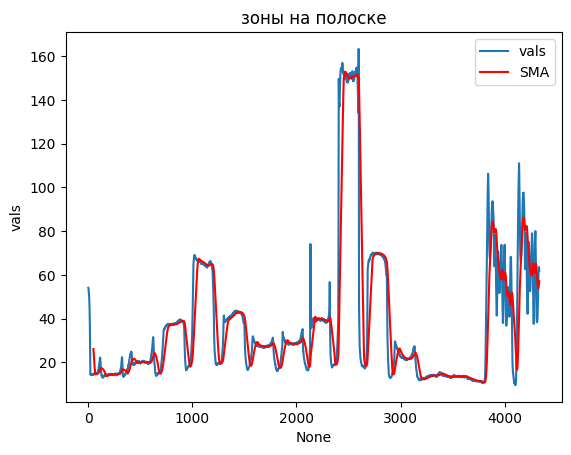

In [296]:
fig, ax=plt.subplots()
sns.lineplot(data=dataset, x=dataset.index, y='vals', label = 'vals')
#sns.lineplot(data=dataset, x=dataset.index, y='ewm', color = 'g', label = 'EWM')
sns.lineplot(data=dataset, x=dataset.index, y='sma', color = 'r', label = 'SMA')
ax.set_title('зоны на полоске')

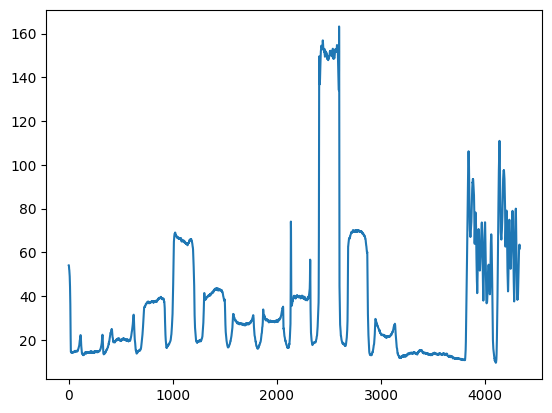

In [267]:
plt.plot(255-gr_sum)
plt.show()

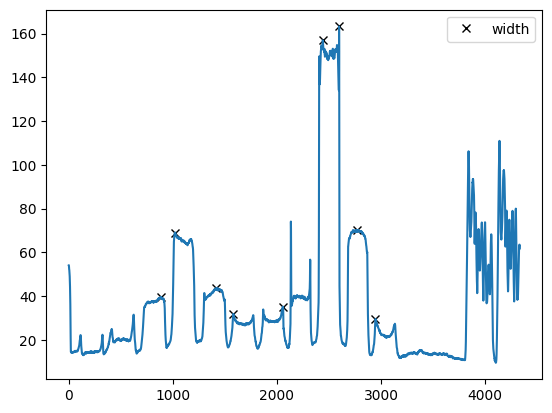

In [262]:
peaks3, _ = sp.find_peaks(inv_gr, width=100)
plt.plot(peaks3, inv_gr[peaks3], "xk"); plt.plot(inv_gr); plt.legend(['width'])
plt.show()

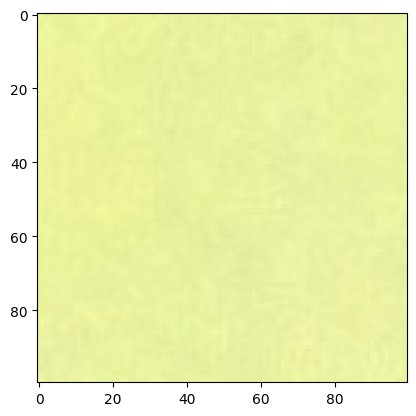

In [446]:
gl = stp0[2175:2275, 70:170, :]
plt.imshow(gl)
plt.show()

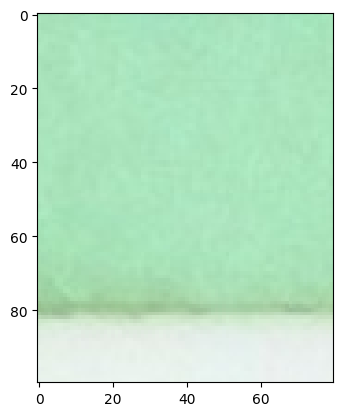

In [821]:
stp = cv2.imread("imgs/glucose/10032024/60_renamed_extracted/010.jpg")
stp = cv2.cvtColor(stp, cv2.COLOR_BGR2RGB)
cnt = int(stp0.shape[1]/2)
gl = stp[2175:2275, cnt-40:cnt+40, :]

plt.imshow(gl)
plt.show()

In [772]:
os.path.join(path2, '001.jpg')

'imgs/glucose/10032024/60_renamed_extracted/001.jpg'